# Neural networks with PyTorch

Next I'll show you how to build a neural network with PyTorch.

In [45]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
# to import the PyTorch library
import torch

import helper

import matplotlib.pyplot as plt
# torchvision is associated with PyTorch and helps in downloading and using some existing datasets 
from torchvision import datasets, transforms 

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [46]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# transforms.ToTensor() changes the images into the tensor
# transforms.Normalize((0.5,), (0.5,)) changes the value of each pixel from -1 to 1 instead of 0 to 1. First (0.5, ) subtract 0.5 from each grayscale pixel, then second (0.5,) divides each grayscale pixel with 0.5


# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# for training we will be using the MNIST dataset
# download= True will download the  MNIST dataset if not already downloaded
# train = True to tell it is for training
# transform = transform will apply the transformation discussed above
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# to select the batch size of 64 shuffled dataset from the training set
# whenever we load data from trainloader, we will be getting 64 images

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [47]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

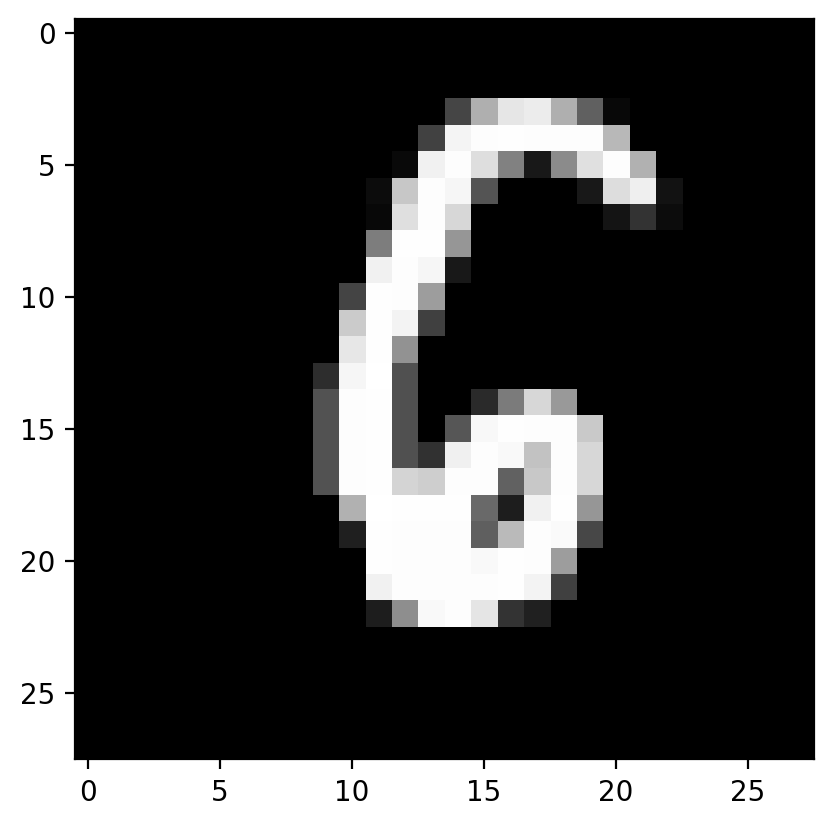

In [48]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [11]:
from torch import nn # neural network functions
from torch import optim 
import torch.nn.functional as F # functional formula to have more functions around neural network

In [49]:
# most generic way is by creating a class in the python
class Network(nn.Module): # we create a class Network which is subclass of nn.Module
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128) # applies a linear transformation to the incoming data y = Ax + b. Attributes are input and the output size. fc here means fully connected layers
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x): # x means a pytorch tensor and we need to pass tensor to each of the layers
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1) # dim means the dimension across which we want to calculate softmax upon
        # since we are passing the batches so the 0th dimension will be batch size
        # so the actual vector will be dimension 1
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [50]:
print(model.fc1.weight) 
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0159,  0.0068, -0.0263,  ..., -0.0004, -0.0282, -0.0233],
        [-0.0172,  0.0328,  0.0019,  ..., -0.0129,  0.0176,  0.0342],
        [-0.0238,  0.0065, -0.0112,  ..., -0.0240, -0.0287,  0.0316],
        ...,
        [-0.0162,  0.0133, -0.0324,  ..., -0.0207,  0.0154,  0.0232],
        [ 0.0329, -0.0278,  0.0174,  ...,  0.0063,  0.0118, -0.0098],
        [ 0.0265,  0.0064, -0.0171,  ..., -0.0178, -0.0063, -0.0135]],
       requires_grad=True)
Parameter containing:
tensor([-0.0284, -0.0208, -0.0038,  0.0050,  0.0260, -0.0328,  0.0100, -0.0201,
         0.0086, -0.0273, -0.0179,  0.0275, -0.0184, -0.0325, -0.0055, -0.0288,
         0.0185, -0.0244,  0.0054, -0.0251,  0.0354,  0.0203, -0.0108,  0.0253,
         0.0347, -0.0149,  0.0199,  0.0244,  0.0106, -0.0346,  0.0219,  0.0110,
        -0.0090, -0.0138,  0.0087,  0.0083,  0.0152, -0.0310,  0.0043,  0.0110,
         0.0262,  0.0151,  0.0048,  0.0113, -0.0071, -0.0316,  0.0028, -0.0235,
        -0.0102

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [52]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [53]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 4.4601e-03, -1.2254e-02,  7.8399e-03,  ..., -4.2255e-03,
         -4.8827e-03,  8.1612e-03],
        [ 2.7877e-05, -2.3694e-02,  4.1818e-03,  ...,  7.7719e-03,
         -4.1011e-03,  1.5975e-02],
        [-1.1361e-02, -5.2463e-03,  7.7493e-03,  ...,  1.3900e-02,
         -1.2312e-03, -9.0527e-03],
        ...,
        [ 3.1920e-02,  6.7647e-03,  1.1057e-02,  ...,  6.0816e-03,
         -6.4772e-03,  2.8945e-04],
        [ 1.2067e-02,  1.1979e-03,  1.4239e-03,  ...,  1.1921e-03,
         -1.7831e-02,  1.1157e-02],
        [ 1.5440e-02,  7.6052e-03,  1.9765e-02,  ..., -5.8420e-03,
         -8.6121e-03,  2.3393e-02]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

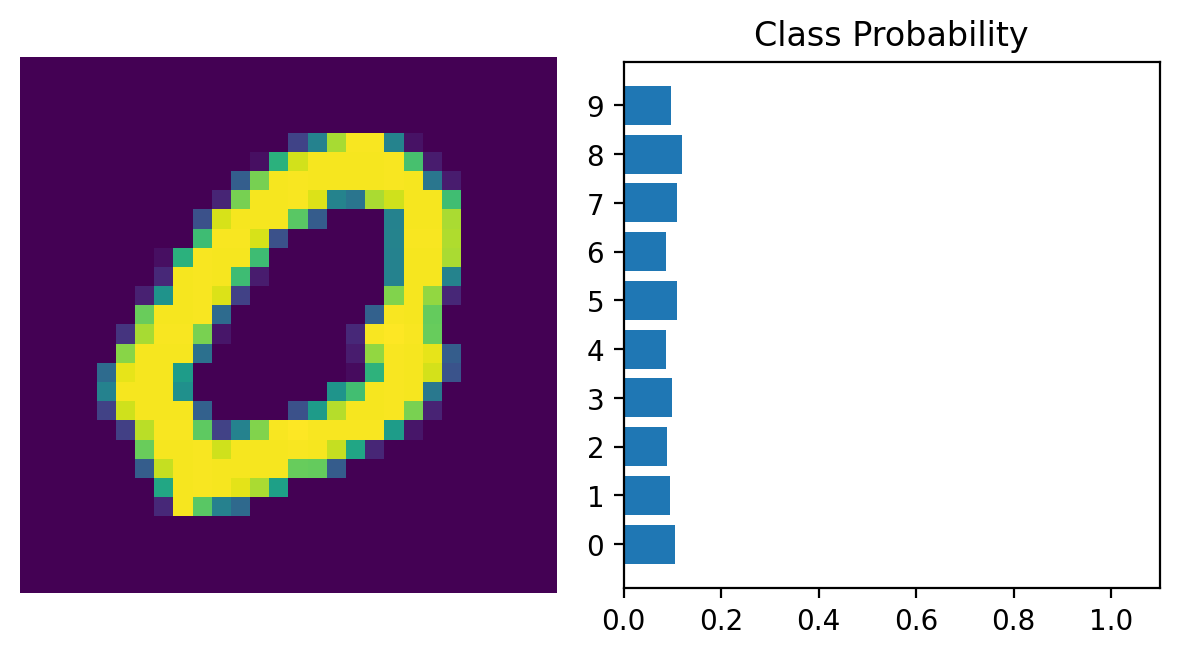

In [74]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = next(dataiter) # labels represent the actual value of the images
# trainloader returns a generator, to make it something we can iterate over we use iter(), to get the first value of that we use next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:]) # ps stands for the probabilities, it helps to see the probability distribution of the output

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps) # to view the image and probabilities side by side

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


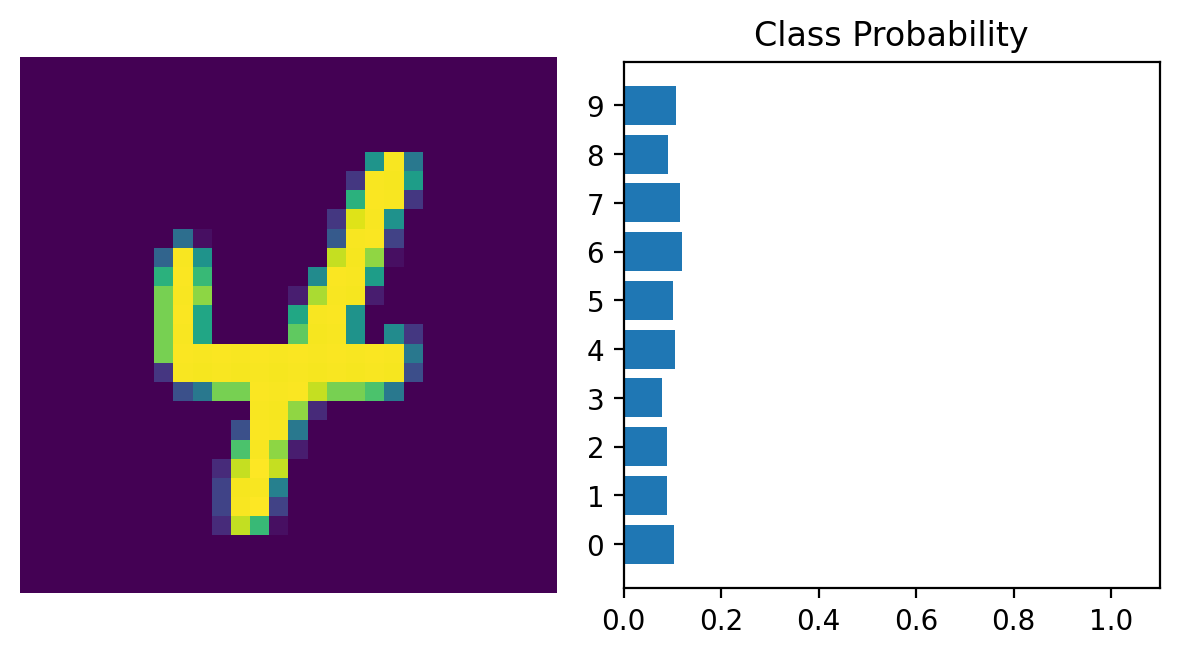

In [75]:
# Hyperparameters for our network (these are the parameters that define the architecture of out network)
# Parameters are the weights and the biases itself
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[1], output_size),
                    nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [78]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                    ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                    ('relu1', nn.ReLU()),
                    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                    ('relu2', nn.ReLU()),
                    ('output', nn.Linear(hidden_sizes[1], output_size)),
                    ('softmax', nn.Softmax(dim=1))]))
print(model)
model.fc2

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


Linear(in_features=128, out_features=64, bias=True)

Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.

>**Exercise:** Build a network to classify the MNIST images with _three_ hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer. 

In [82]:
## TODO: Your network here
from collections import OrderedDict
input_size = 784
hidden_sizes = [400, 200, 100]
output_size = 10


model = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                        ('relu1', nn.ReLU()),
                        ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                        ('relu2', nn.ReLU()),
                        ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                        ('relu3', nn.ReLU()),
                        ('output', nn.Linear(hidden_sizes[2], output_size)),
                        ('softmax', nn.Softmax(dim=1))
]))

model

Sequential(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

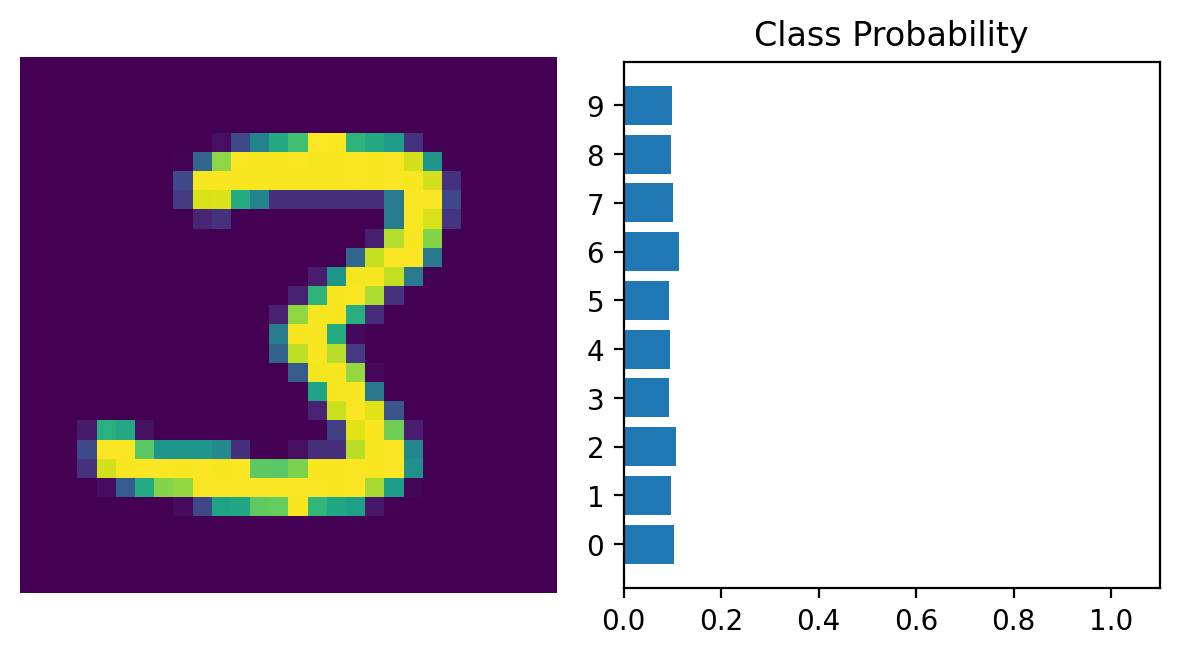

In [85]:
## Run this cell with your model to make sure it works ##
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)